In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
# import seaborn as sns
# sns.set_palette("hls")

## Read Data

In [4]:
c_perp = pd.read_csv('perp_data/TRAIN_PATH_CPERPLEXITY.csv')
x_perp = pd.read_csv('perp_data/TRAIN_PATH_XPERPLEXITY.csv')
combine = pd.merge(c_perp,x_perp)

In [3]:
print('Nums of Training Example :',len(combine))

Nums of Training Example : 1281167


## Draw Curve

In [42]:
def get_nums(percentile):
    c_threshold = np.percentile(combine['C_PERPLEXITY'],percentile)
    x_threshold = np.percentile(combine['X_PERPLEXITY'],percentile)
    pruned_c = np.sum(combine['C_PERPLEXITY'] > c_threshold)
    pruned_x = np.sum(combine['X_PERPLEXITY'] > x_threshold)
    pruned_both = combine[(combine['C_PERPLEXITY'] > c_threshold) & (combine['X_PERPLEXITY'] > x_threshold)].shape[0]
    pruned_or = combine[(combine['C_PERPLEXITY'] > c_threshold) | (combine['X_PERPLEXITY'] > x_threshold)].shape[0]
    return pruned_c,pruned_x,pruned_both,pruned_or
def get_frac(p):
    pc,px,pb,po = p
    N = 1281167
    return pc/N,px/N,pb/N,po/N

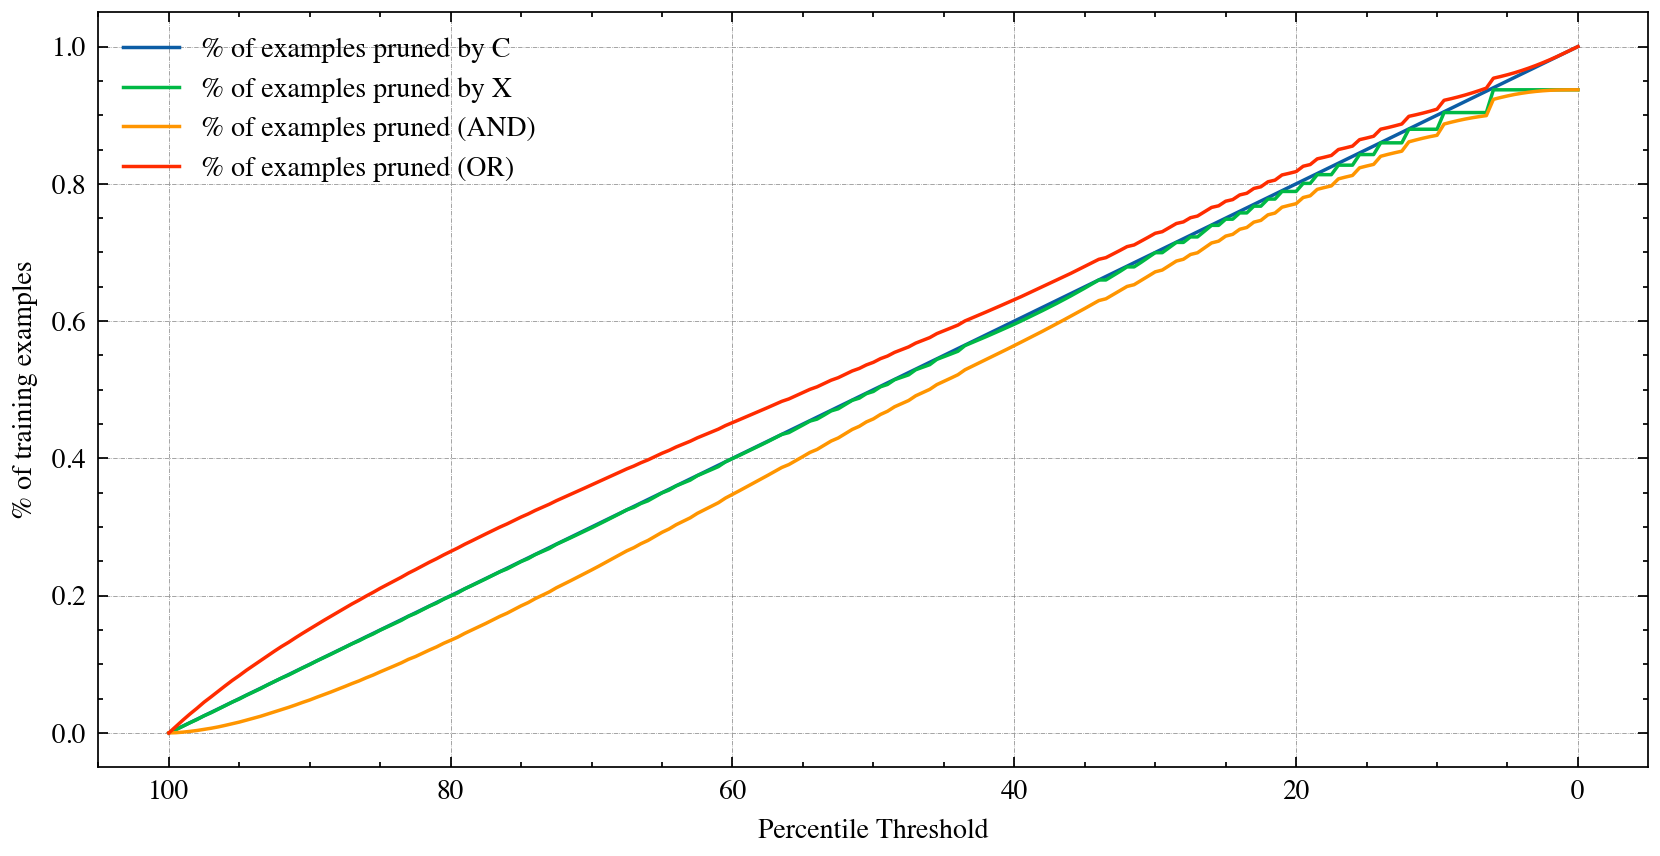

In [44]:
plt.style.use(['science','ieee','std-colors','no-latex'])
fig = plt.figure(figsize=[8,4],dpi=250)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
x = np.linspace(100,0,201)
lineObjects = plt.plot(x,[get_frac(get_nums(i)) for i in x])
plt.gca().invert_xaxis()
plt.legend(iter(lineObjects), ('% of examples pruned by C','% of examples pruned by X', '% of examples pruned (AND)','% of examples pruned (OR)'))
plt.xlabel('Percentile Threshold')
plt.ylabel('% of training examples')
plt.savefig('img/percent_of_pruned.png',dpi=200)

## Threshold Pruning

In [5]:
threshold_percentile = 90
c_threshold = np.percentile(combine['C_PERPLEXITY'],threshold_percentile)
x_threshold = np.percentile(combine['X_PERPLEXITY'],threshold_percentile)
print("The number of examples with C Perplexity greater than the c_threshold : ",np.sum(combine['C_PERPLEXITY'] > c_threshold))
print("The number of examples with X Perplexity greater than the x_threshold : ",np.sum(combine['X_PERPLEXITY'] > x_threshold))
print("THe number of examples >c_threshold AND >threshold :",combine[(combine['C_PERPLEXITY'] > c_threshold) & (combine['X_PERPLEXITY'] > x_threshold)].shape[0])
print("THe number of examples >c_threshold OR >threshold :",combine[(combine['C_PERPLEXITY'] > c_threshold) | (combine['X_PERPLEXITY'] > x_threshold)].shape[0])

The number of examples with C Perplexity greater than the c_threshold :  1281166
The number of examples with X Perplexity greater than the x_threshold :  1200438
THe number of examples >c_threshold AND >threshold : 1200438
THe number of examples >c_threshold OR >threshold : 1281166


#### Since we try to clean the training dataset as possbile, we should prune examples satisfied with at least one conditions.

#### Before pruning the example, first we need calculate the number of pruned examples of each label.

In [78]:
def get_class(path):
    """
    Return the label the example belogns to according to path
    """
    return path.split('/')[2]
id_label_map = pd.read_csv('data/id_label_map.csv')
mapper = dict(zip(id_label_map['Nums'],id_label_map['Label']))

In [79]:
label_nums = Counter(combine['PATH'].apply(get_class)) #a dictionary record (label,# of training data)

In [80]:
prune = combine[(combine['C_PERPLEXITY'] > c_threshold) | (combine['X_PERPLEXITY'] > x_threshold)]
prune_label_nums = Counter(prune['PATH'].apply(get_class)) #a dictionary record (label,# of pruned data)
prune_label_nums = {k: v for k, v in sorted(prune_label_nums.items(), key=lambda item: item[1],reverse=True)} #sort dict on value in desc order

### Plot the Top 10 pruned label

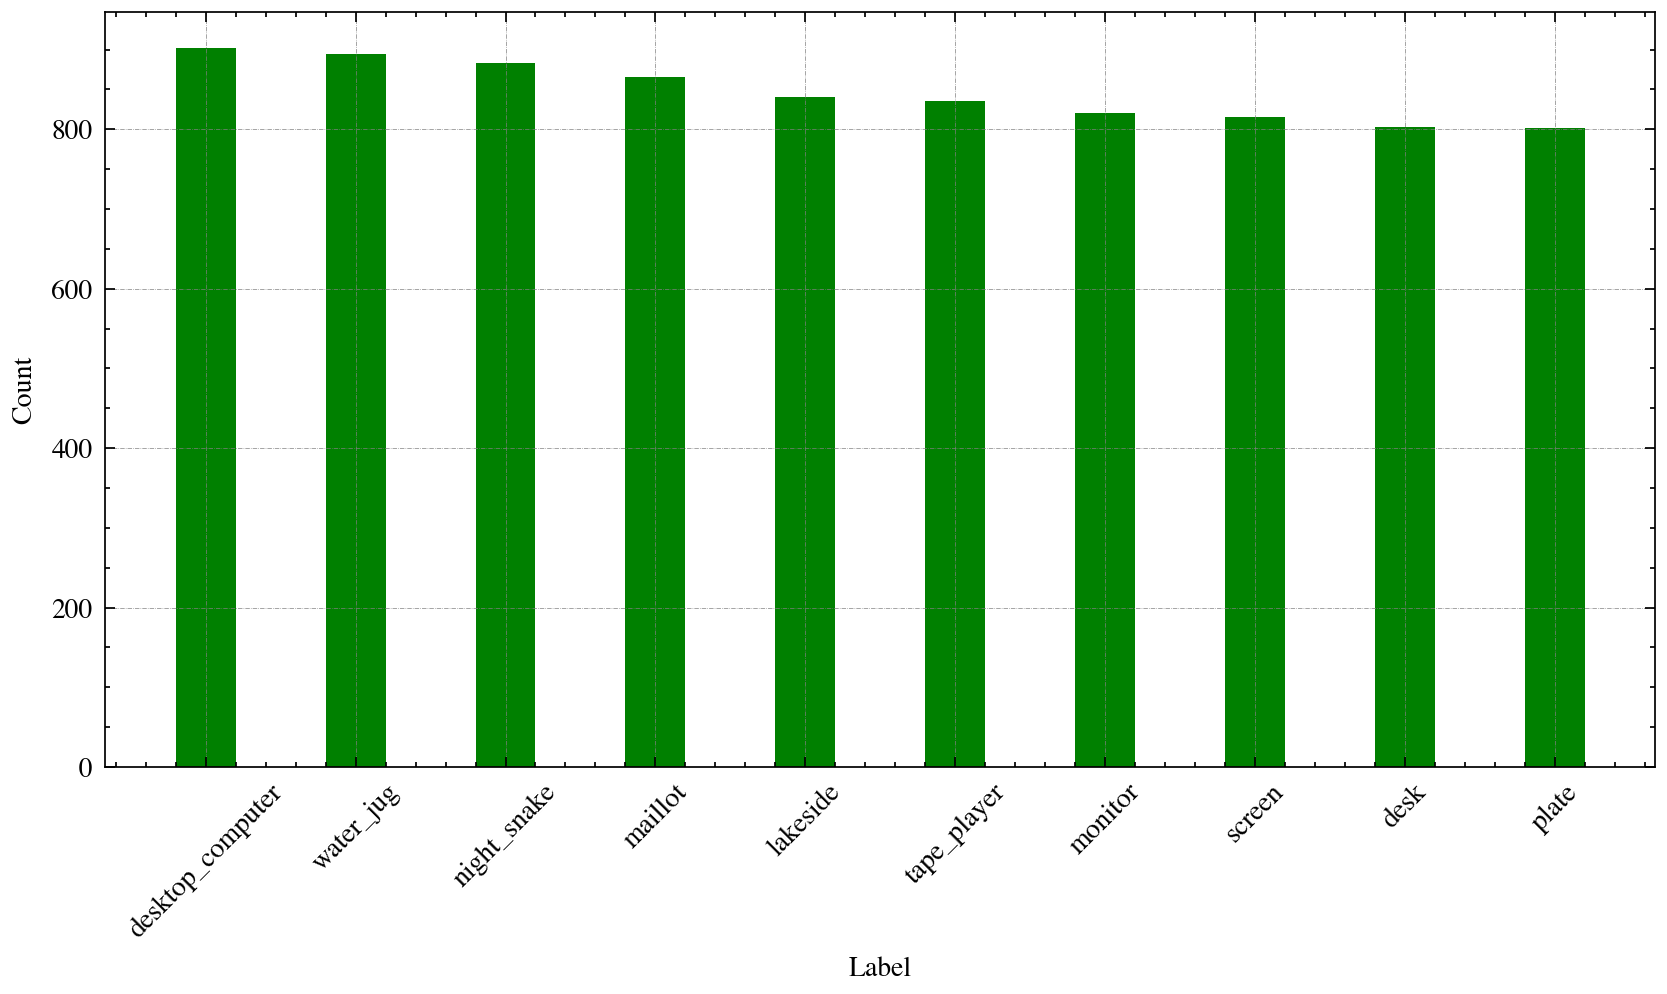

In [81]:
plt.style.use(['science','ieee','std-colors','no-latex'])
fig = plt.figure(figsize=[8,4],dpi=250)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.bar(list(map(mapper.get, list(prune_label_nums.keys())[0:10])),list(prune_label_nums.values())[0:10],width=0.4,color='green')
plt.xticks(rotation=45);
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('img/TOP_10_pruned_label_85.png',dpi=250, facecolor=fig.get_facecolor(),bbox_inches='tight')

## Plot the TOP-10 pruned fraction of Labels

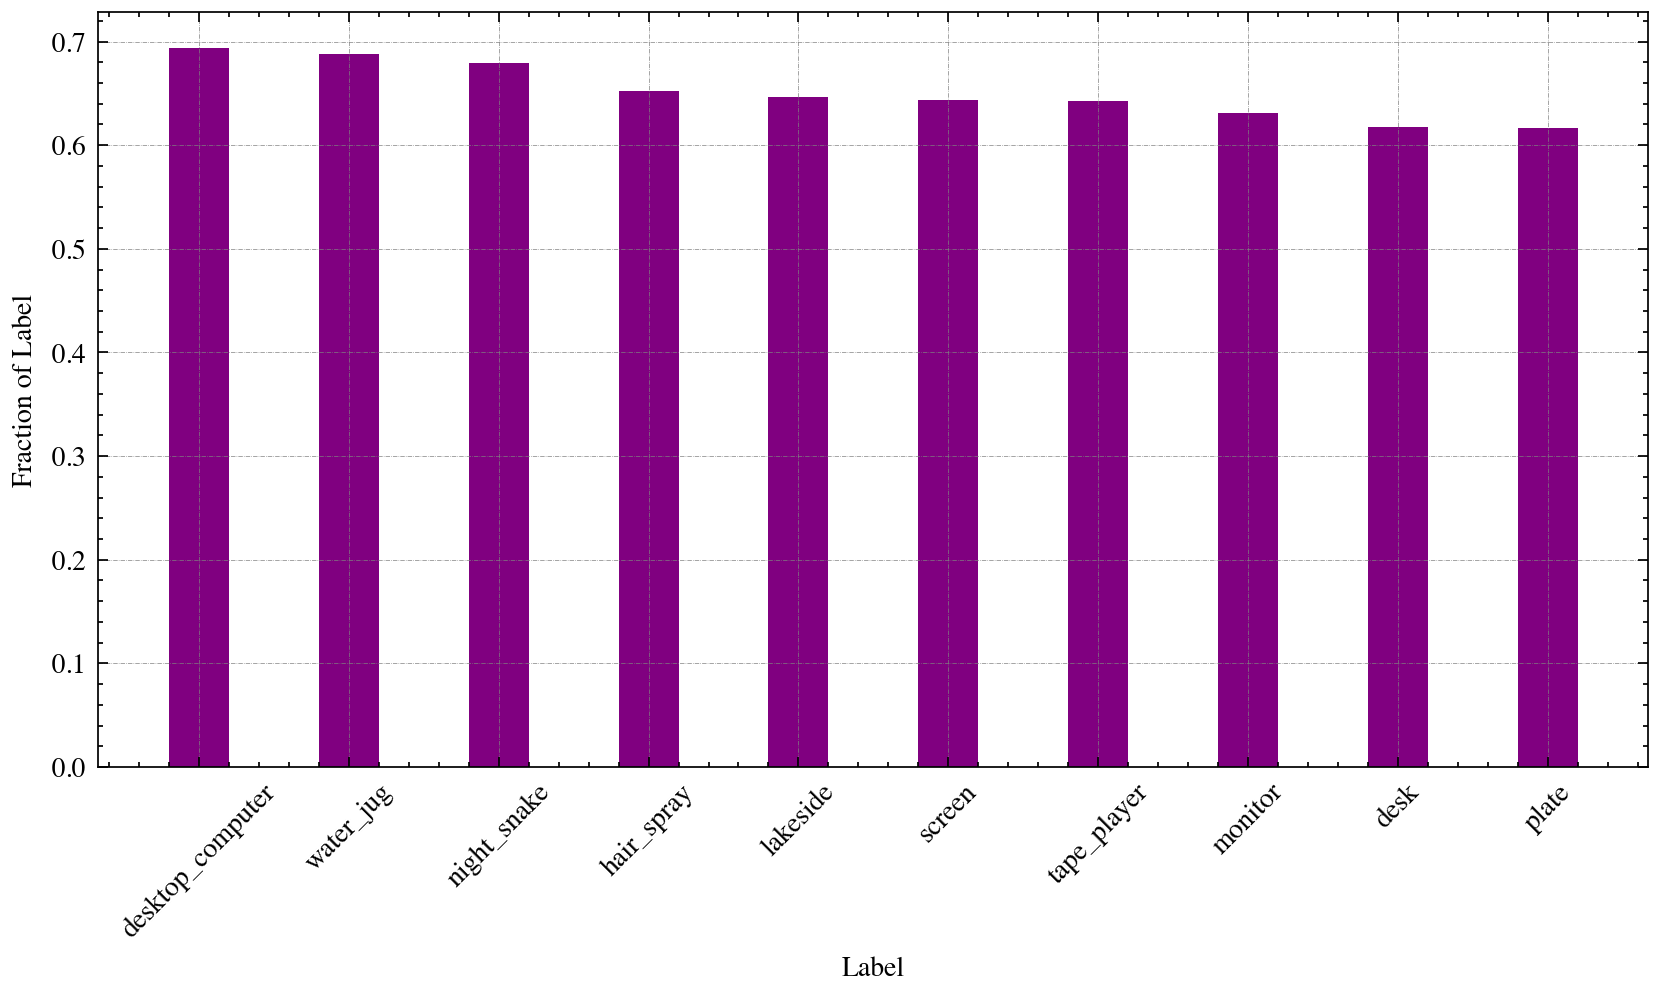

In [82]:
pruned_frac = {mapper[k]:prune_label_nums[k]/label_nums[k] for k in prune_label_nums.keys()} #calculate the fraction of pruned examples for classes will be pruned
pruned_frac = {k: v for k, v in sorted(pruned_frac.items(), key=lambda item: item[1],reverse=True)} #sort dict on value in desc order
plt.style.use(['science','ieee','std-colors','no-latex'])
fig = plt.figure(figsize=[8,4],dpi=250)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.bar(list(pruned_frac.keys())[0:10],list(pruned_frac.values())[0:10],width=0.4,color='purple')
plt.xticks(rotation=45);
plt.xlabel('Label')
plt.ylabel('Fraction of Label')
plt.savefig('img/TOP_10_frac_pruned_label_85.png',dpi=200, facecolor=fig.get_facecolor(),bbox_inches='tight')

#### Output the pruned Training dataset

In [83]:
mapper = pd.read_csv('data/id_label_map.csv')
id_label = dict(zip(mapper['ID'],mapper['Label']))
folder_id= dict(zip(mapper['Nums'],mapper['ID']))
def replace_path(x):
    return x.replace('./ILSVRC2012_img_train','/4tssd/imagenet/train')
def get_label(x):
    return folder_id[x.split('/')[4]]

In [84]:
combine = combine.drop(index = prune.index)
combine = combine.reset_index().drop(labels='index',axis=1) #reset index
combine = combine.sample(frac = 1) #shuffle the training data for training
combine['PATH'] = combine['PATH'].apply(replace_path)
combine['LABEL'] = combine['PATH'].apply(get_label)
combine.to_csv('data/'+str(threshold_percentile)+'_PRUNED_TRAINING_85.csv',index=None)

#### Record the count of pruned examples for later data augmentation

In [85]:
labels,pruned_count = list(prune_label_nums.keys()),list(prune_label_nums.values())
pd.DataFrame({'LABEL':labels,'PRUNED_COUNT':pruned_count}).to_csv('data/'+str(threshold_percentile)+'_PRUNED_COUNT_85.csv',index=None)